# Calculating dust uplift potential over North Africa

In [1]:
import sys
import os
sys.path.append(os.path.abspath("/work/bb1198/StormCC"))
from loadwindera5_AL import load_wind_data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import xarray as xr
from global_land_mask import globe
import numpy as np
import pandas as pd
import dask

ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj failed


In [2]:
def plot_parameter(parameter,title="Parameter",label="[1]",mask=False,cmap="viridis"):
    # Gitter für Konturplot erzeugen
    lon_subset=parameter.lon.values
    lat_subset=parameter.lat.values
    lon_grid = np.arange(lon_min+lon_subset[1]-lon_subset[0],lon_max-(lon_subset[1]-lon_subset[0]), lon_subset[1]-lon_subset[0])
    lat_grid = np.arange(lat_min-min(lat_subset[1:]-lat_subset[:-1]), lat_max+min(lat_subset[1:]-lat_subset[:-1]), -min(lat_subset[1:]-lat_subset[:-1]))
    lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
    # Interpolation der Werte auf das 2D-Gitter
    value_grid = griddata((lon_subset, lat_subset), parameter, (lon2d, lat2d), method='cubic')
    if (mask):
        land_mask = ~globe.is_ocean(lat2d, lon2d) 
        value_grid=np.where(land_mask, value_grid,np.nan)
    # Plotten
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    im=ax.contourf(lon2d, lat2d, value_grid, levels=15, cmap=cmap,extent=extend,extend="both",transform=ccrs.PlateCarree())
    fig.colorbar(im, orientation='horizontal',location="bottom",label=label)
    fig.suptitle(title)
    fig.savefig(title+".png")

In [3]:
file_pattern = "/work/bb1198/StormCC/era5yearly1H/era5_wind_speed_*.nc"  # oder eine Liste: ["data_2000.nc", "data_2001.nc", ...]


# 3. Dataset einlesen und kombinieren
ds = xr.open_mfdataset(
    file_pattern,
    combine="by_coords",       # Kombiniert über Zeitkoordinaten
    parallel=True              # Parallelisierung (optional, bei Dask)
)
ds["lon"] = ((ds["lon"] + 180) % 360) - 180
# 2. Maske für gewünschten Ausschnitt erstellen (z. B. Europa)
lat_min, lat_max = 0, 50
lon_min, lon_max = -30, 40

mask = (
    (ds.lat >= lat_min) & (ds.lat <= lat_max) &
    (ds.lon >= lon_min) & (ds.lon <= lon_max)
)

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds_region = ds.sel(location=mask)

In [4]:
extend=[-30, 40,0, 50 ]

## Mean wind speed

In [5]:
try:
    wind_mean=xr.open_dataset("/work/bb1198/StormCC/ws_monthly_mean/monthly_mean.nc")
except:
    wind_mean=ds_region.wind_speed.groupby("time.month").mean(dim="time").compute()
    wind_mean.to_netcdf("/work/bb1198/StormCC/ws_monthly_mean/monthly_mean.nc")
wind_mean=wind_mean.mean(dim="month").compute().wind_speed

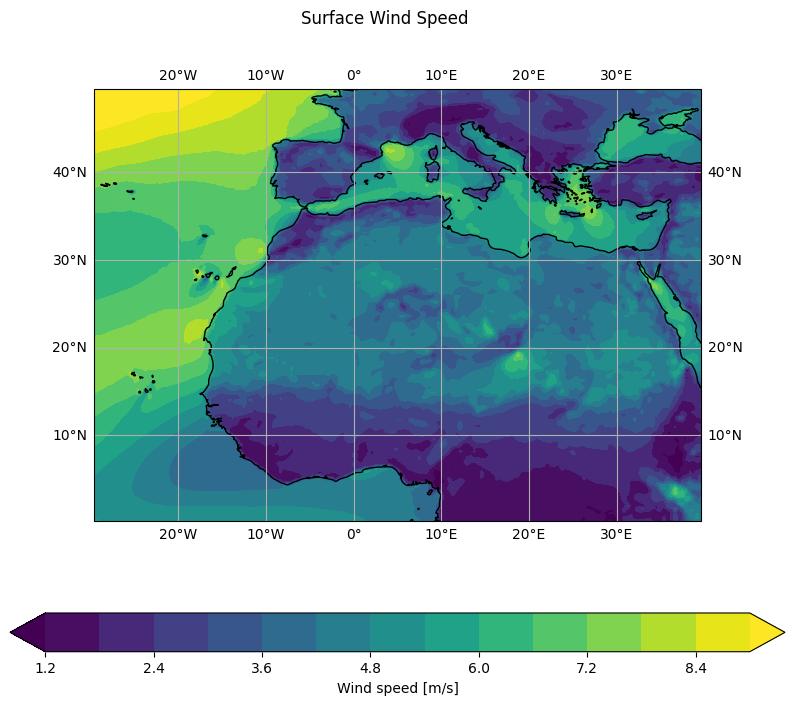

In [6]:
plot_parameter(wind_mean,title="Surface Wind Speed",label="Wind speed [m/s]")

## Mean Dust Uplift Potential

In [7]:
try:
    DUP_mean=xr.open_dataset("/work/bb1198/StormCC/dup_monthly_mean/dup_monthly_mean.nc")
except:
    U=ds_region.wind_speed
    U_t=7
    nu=1
    DUP=nu*U**3*(1+U_t/U)*(1-U_t**2/U**2)*(U>U_t)
    DUP_mean=DUP.groupby("time.month").mean(dim="time").compute()
    DUP_mean.to_netcdf("/work/bb1198/StormCC/dup_monthly_mean/dup_monthly_mean.nc")
DUP_mean=DUP_mean.mean(dim="month").compute().wind_speed

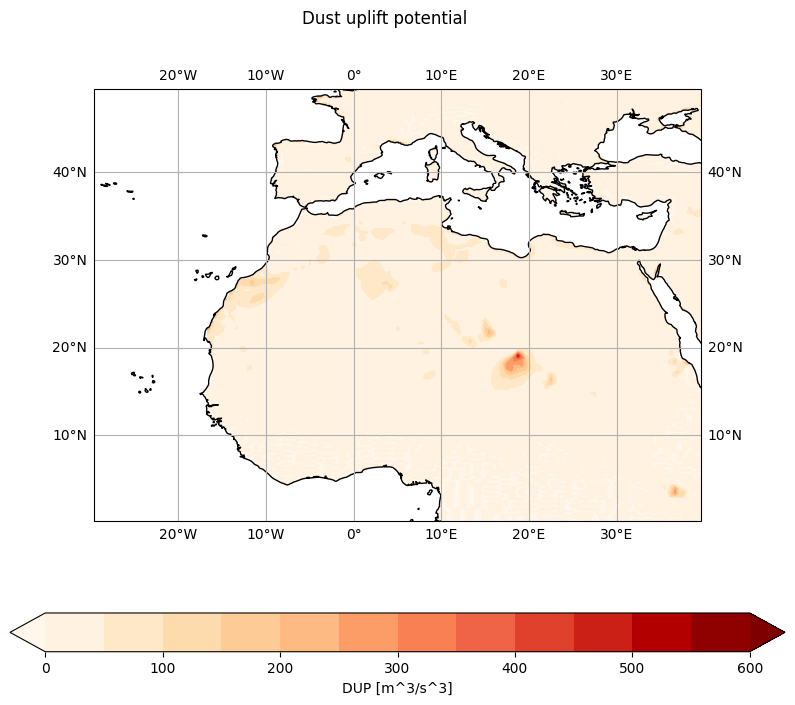

In [8]:
plot_parameter(DUP_mean,title="Dust uplift potential",label="DUP [m^3/s^3]",mask=True,cmap="OrRd")

## DUP time series

In [9]:
try:
    DUP_annual=xr.open_dataset("/work/bb1198/StormCC/dup_annual_mean/dup_annual_mean.nc").mean(dim="location").compute()
except:
    DUP_spatial_mean=DUP.mean(dim="location").compute()
    series=pd.Series(data=DUP_spatial_mean, index=pd.to_datetime(DUP_spatial_mean.time))
    DUP_annual = series.resample('YE').mean()

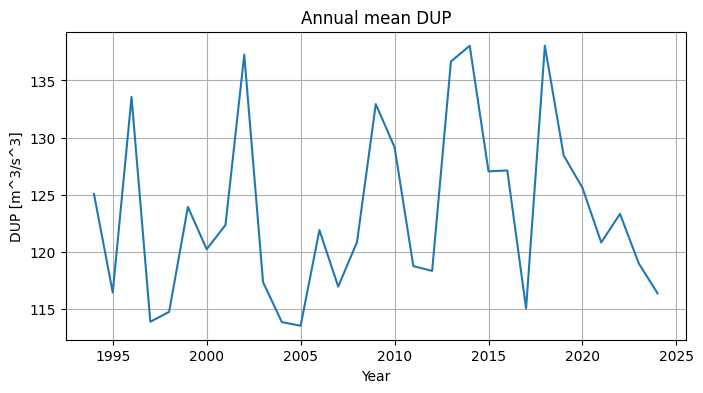

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(DUP_annual.year, DUP_annual.wind_speed)
plt.xlabel("Year")
plt.ylabel("DUP [m^3/s^3]")
plt.title("Annual mean DUP")
plt.grid(True)
plt.savefig("annual_mean_DUP.png")
plt.show()


## DUP Seasonality

In [11]:
try:
    DUP_monthly_means=xr.open_dataset("/work/bb1198/StormCC/dup_monthly_mean/dup_monthly_mean.nc").mean(dim="location").compute()
except:
    DUP_monthly_means =series.groupby(series.index.month).mean()
months=['Jan', 'Feb', 'Mar', 'Apr', 'May',"Jun", 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

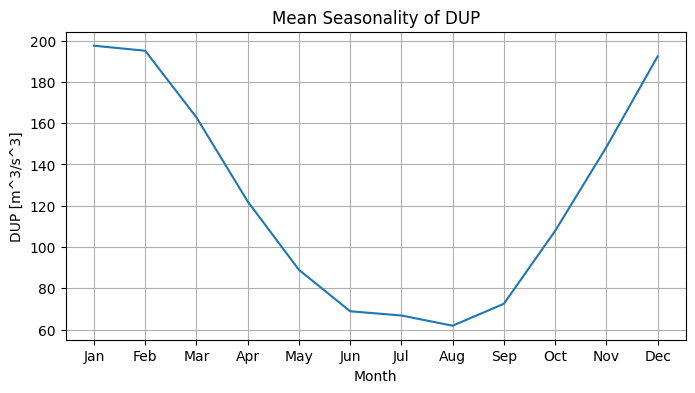

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(months, DUP_monthly_means.wind_speed)
plt.xlabel("Month")
plt.ylabel("DUP [m^3/s^3]")
plt.title("Mean Seasonality of DUP")
plt.grid(True)
plt.savefig("DUP_seasonality.png")
plt.show()


### Seasonal maps

In [10]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    elif month in [9, 10, 11]:
        return 'SON'

In [22]:
try:
    seasonal_maps=xr.open_dataset("/work/bb1198/StormCC/ws_monthly_mean/monthly_mean.nc")
    # Wende diese Funktion auf die Monate an
    seasons = xr.DataArray(
        [month_to_season(m.item()) for m in seasonal_maps.month],
        coords={"month": seasonal_maps.month},
        dims="month"
    )
    seasonal_maps =seasonal_maps.assign_coords(season=seasons).groupby("season").mean().compute()    
except:
    seasonal_maps=ds_region.wind_speed.groupby("time.season").mean().compute()

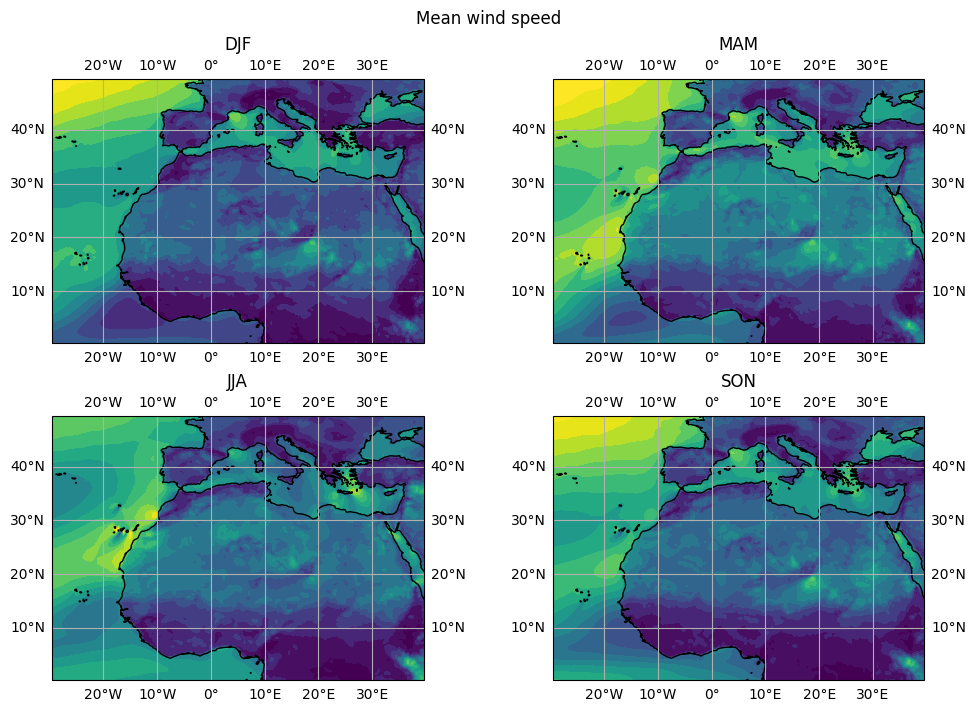

In [23]:
proj = ccrs.PlateCarree()
fig,ax=plt.subplots(2,2,figsize=(10,7),subplot_kw={'projection': proj},constrained_layout=True)
mask=False
# Gitter für Konturplot erzeugen
lon_subset=seasonal_maps.wind_speed.lon.values
lat_subset=seasonal_maps.wind_speed.lat.values
lon_grid = np.arange(lon_min+lon_subset[1]-lon_subset[0],lon_max-(lon_subset[1]-lon_subset[0]), lon_subset[1]-lon_subset[0])
lat_grid = np.arange(lat_min-min(lat_subset[1:]-lat_subset[:-1]), lat_max+min(lat_subset[1:]-lat_subset[:-1]), -min(lat_subset[1:]-lat_subset[:-1]))
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
for j in range(2):
    for i in range(2):
        value_grid = griddata((lon_subset, lat_subset), seasonal_maps.isel(season=i*2+j).wind_speed, (lon2d, lat2d), method='cubic')
        if (mask):
            land_mask = ~globe.is_ocean(lat2d, lon2d) 
            value_grid=np.where(land_mask, value_grid,np.nan)

        ax[j,i].coastlines()
        ax[j,i].gridlines(draw_labels=True)
        im=ax[j,i].contourf(lon2d, lat2d, value_grid, levels=15, cmap="viridis",extent=extend,extend="both",transform=ccrs.PlateCarree())
        ax[j,i].set_title(str(seasonal_maps_DUP.season[i*2+j].values))
fig.suptitle("Mean wind speed")
fig.savefig("seasonal_wind.png")

In [11]:
try:
    seasonal_maps_DUP=xr.open_dataset("/work/bb1198/StormCC/dup_monthly_mean/dup_monthly_mean.nc")
    # Wende diese Funktion auf die Monate an
    seasons = xr.DataArray(
        [month_to_season(m.item()) for m in seasonal_maps_DUP.month],
        coords={"month": seasonal_maps_DUP.month},
        dims="month"
    )
    seasonal_maps_DUP =seasonal_maps_DUP.assign_coords(season=seasons).groupby("season").mean().compute()
except:
    print("Fail")
    #U=ds_region.wind_speed
    #U_t=6
    #nu=1
    #DUP=nu*U**3*(1+U_t/U)*(1-U_t**2/U**2)*(U>U_t)
    #seasonal_maps_DUP=DUP.groupby("time.season").mean().compute()

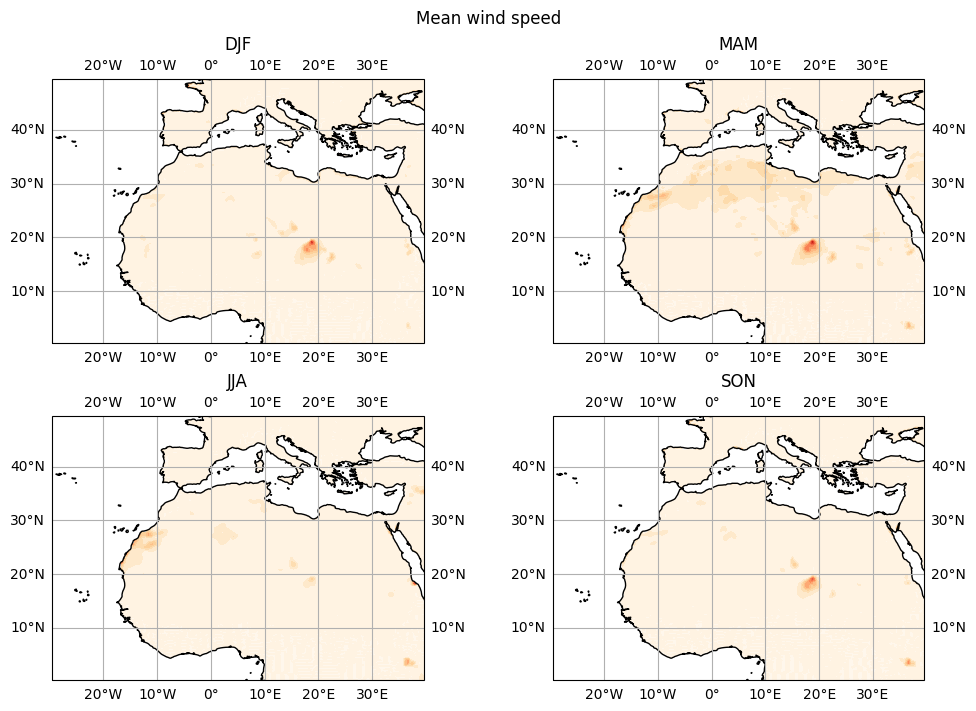

In [19]:
proj = ccrs.PlateCarree()
fig,ax=plt.subplots(2,2,figsize=(10,7),subplot_kw={'projection': proj},constrained_layout=True)
mask=True
# Gitter für Konturplot erzeugen
lon_subset=seasonal_maps_DUP.wind_speed.lon.values
lat_subset=seasonal_maps_DUP.wind_speed.lat.values
lon_grid = np.arange(lon_min+lon_subset[1]-lon_subset[0],lon_max-(lon_subset[1]-lon_subset[0]), lon_subset[1]-lon_subset[0])
lat_grid = np.arange(lat_min-min(lat_subset[1:]-lat_subset[:-1]), lat_max+min(lat_subset[1:]-lat_subset[:-1]), -min(lat_subset[1:]-lat_subset[:-1]))
lon2d, lat2d = np.meshgrid(lon_grid, lat_grid)
for j in range(2):
    for i in range(2):
        value_grid = griddata((lon_subset, lat_subset), seasonal_maps_DUP.isel(season=i*2+j).wind_speed, (lon2d, lat2d), method='cubic')
        if (mask):
            land_mask = ~globe.is_ocean(lat2d, lon2d) 
            value_grid=np.where(land_mask, value_grid,np.nan)

        ax[j,i].coastlines()
        ax[j,i].gridlines(draw_labels=True)
        im=ax[j,i].contourf(lon2d, lat2d, value_grid, levels=15, cmap="OrRd",extent=extend,extend="both",transform=ccrs.PlateCarree())
        ax[j,i].set_title(str(seasonal_maps_DUP.season[i*2+j].values))
fig.suptitle("Mean wind speed")
fig.savefig("seasonal_dup.png")